# What is inside a "yield input package" (YIP)?
**A yield input package encodes a coronagraph's response** in three different scenarios:
1. A point source not in the center of the image, called an "off-axis PSF". The most obvious example is a planet.
2. A central source for different angular diameters, these are called "stellar intensity maps". This represents the coronagraph's response to a star.
3. An extended source. This is most commonly used for local zodiacal light, or the dust in the solar system the telescope has to point through.

The standard use-case for them is to determine the photon count rates of objects in a simulated image.

## YIP files
The necessary files for a yield input package are shown below with their default names.

In [43]:
from pathlib import Path

# Path to the yield input package directory
yip_path = Path("../../input/ApodSol_APLC")

# Printing out each file in YIP
for item in sorted(yip_path.iterdir()):
    print(item.name)

offax_psf.fits
offax_psf_offset_list.fits
sky_trans.fits
stellar_intens.fits
stellar_intens_diam_list.fits


## YIP file descriptions
### Off-axis PSF files
The `offax_psf.fits` and `offax_psf_offset_list.fits` files describe the PSFs produced by a planet at $(x, y)$ values.
#### `offax_psf.fits`
3d array of PSF maps as a function of $(x, y, k)$. In $(x, y)$ we have standard 2d images that show the PSF. The value at a pixel is the count rate in that pixel divided by the total count rate of the image. The offset $k$ (an integer corresponding to an $(x, y)$ value in the `offax_psf_offset_list.fits` file) represents the astrophysical offset of the source in units of $\lambda / D$. The images are normalized to the total count rate entering the coronagraph.
#### `offax_psf_offset_list.fits`
$2 \times N_k$ array with $(x, y)$ values for each astrophysical offset in the `offax_psf.fits` file, where $N_k$ is the number of offsets $k$. These offsets should adequately sample the space such that the interpolation is valid.

There are three potential cases here, the provided PSFs can be radially symmetric, quarter symmetric, or in full 2D. The best place to start learning about that is the [radially symmetric example](RadiallySymmetric.ipynb). There is also an example for a [quarter symmetric](QuarterSymmetric.ipynb) coronagraph.

- - -

### Stellar intensity files
The `stellar_intens.fits` and `stellar_intens_diam_list.fits` files describe the coronagraph's response to stars of different diameters in the center of the image.
#### `stellar_intens.fits`
A unitless 3d array of the stellar intensity function $I$, as a function of $(x, y)$ pixel coordinates and the stellar angular diameter $\theta_\textrm{star}$. Values in the map are equal to the stellar count rate in a given pixel divided by the total stellar count rate entering the coronagraph. This does not include reductions such as $QE$, which means that without the coronagraph the sum of $I$ would be unity.
#### `stellar_intens_diam_list.fits`
A list of stellar diameter values $\lambda / D$ corresponding to the $\theta_\textrm{star}$ values in stellar_intens.

To understand this better go to [the stellar intensity example](StellarIntens.ipynb).

- - -

### Sky transmission map
#### `sky_trans.fits`
A unitless 2d array, $T_\textrm{sky}(x,y)$, of the mathematical coronagraphic throughput of an infinitely extended source such as dust in our solar system.

## Quickstart
### Load a coronagraph.

In [44]:
from yippy import Coronagraph

coro = Coronagraph(yip_path)

[yippy] INFO 2024-06-16 15:26:35,228 [coronagraph.py:__init__:67] Creating ApodSol_APLC coronagraph
[yippy] INFO 2024-06-16 15:26:35,272 [offax_base.py:__init__:117] ApodSol_APLC is quarterly symmetric


### Get the coronagraph response to an off-axis point source
Say we have a point source at $(3,5) \lambda/D$. We will use the `coro.offax(x,y)` function to determine how the coronagraph defined by the YIP would respond. The YIPs are all defined in $\lambda/D$ space and the functions will execute the fastest when given $\lambda/D$ inputs, but `yippy` will handle unit conversion for
1. Angular separation angles (must provide the wavelength and telescope diameter)
2. Apparent separation lengths (must provide the wavelength, telescope diameter, and distance to the star)
3. Pixel (must provide the pixel scale and central pixel)

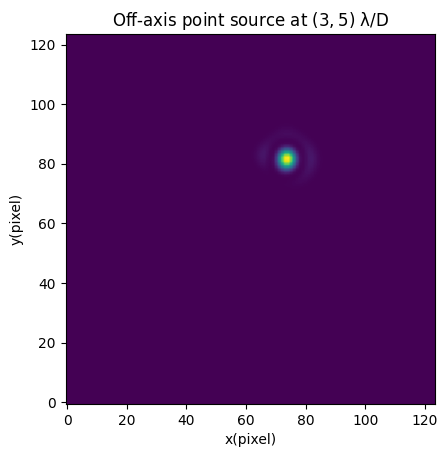

In [45]:
import matplotlib.pyplot as plt
from lod_unit import (
    lod,  # NOTE: `lod` is an astropy unit for lambda/D, I defined it enough that I made it a package
)

x = 3 * lod
y = 5 * lod

planet_psf = coro.offax(x, y)

# Lets plot it
plt.imshow(planet_psf, origin="lower")
plt.xlabel("x(pixel)")
plt.ylabel("y(pixel)")
plt.title(f"Off-axis point source at $(3,5)$ {lod}")
plt.show()

### Get the coronagraph intensity response to a star with angular diameter of 0.5 $\lambda/D$
Now assume you know that your star has an angular diameter ($\theta_\text{star}$) of 0.5 $\lambda/D$, 

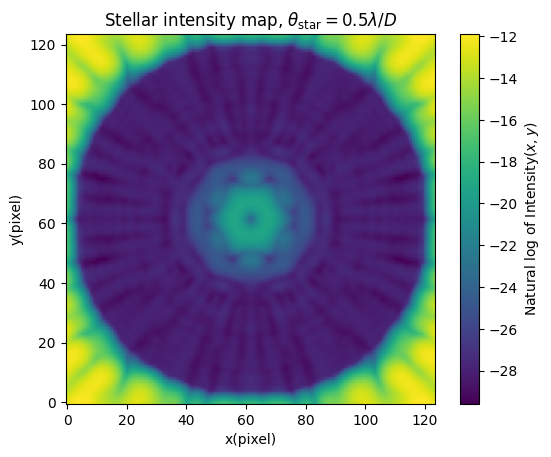

In [46]:
import numpy as np

diam = 0.5 * lod

star_psf = coro.stellar_intens(diam)

plt.imshow(np.log(star_psf), origin="lower")
plt.xlabel("x(pixel)")
plt.ylabel("y(pixel)")
plt.title(f"Stellar intensity map, $\\theta_\\text{{star}}={diam}$")
plt.colorbar(label="Natural log of Intensity$(x,y)$")
plt.show()

### Get the coronagraph transmission map of an infintely extended source
If you're modeling something like the local zodiacal light you'll want to model it as an infinite source which you can use the `coro.sky_trans` for.

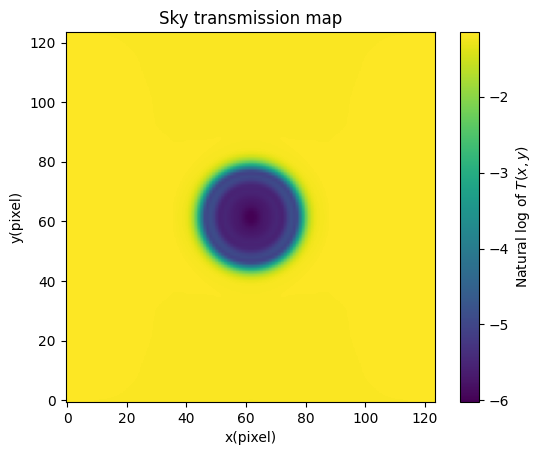

In [47]:
import numpy as np

diam = 0.5 * lod

zodi_psf = coro.sky_trans()

plt.imshow(np.log(zodi_psf), origin="lower")
plt.xlabel("x(pixel)")
plt.ylabel("y(pixel)")
plt.title("Sky transmission map")
plt.colorbar(label="Natural log of $T(x,y)$")
plt.show()

### What do I do with those?
Continue following the examples in the next few pages.

## Important caveats
1. This process involves interpolating image data. The accuracy of this is highly dependent on the provided yield input package having sufficient sampling because we cannot interpolate correctly in sparse regions. We try to throw a warning when the input seems to be insufficient.
2. The files are bandpass integrated. This means that the wavelength dependence of the coronagraph's performance is not included. You can treat things downstream, like the stellar flux and coronagraph transmission, as functions of wavelength but you will not see things like wavelength-dependent speckles.